In [1]:
from math import e as EULER
from copy import deepcopy
from timeit import default_timer as timer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix # sparse matrix

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
DPI = 120

In [2]:
raw_data = pd.read_csv("old_data/raw_metacritic_game_user_comments.csv")
game_info_data = pd.read_csv("src/data/game_info.csv")
train_data = pd.read_csv("src/data/user_data_train_no_comments.csv")
test_data = pd.read_csv("src/data/user_data_test_no_comments.csv")
valid_data = pd.read_csv("src/data/user_data_validation_no_comments.csv")

game_info_data = game_info_data.rename(columns={"Unnamed: 0" : "Id"})

In [3]:
all_data = pd.concat([train_data, test_data, valid_data], ignore_index=True)

In [4]:
all_data

,Unnamed: 0,Userscore,Username,Game_ID
0,47246,9,SergeantSoz,119
1,199743,9,SergeantSoz,1540
2,235823,8,SergeantSoz,2227
3,263595,8,SergeantSoz,2941
4,72338,9,tomcrew10,238
...,...,...,...,...
151992,242135,10,AlexN.,2375
151993,258319,9,AlexN.,2834
151994,17628,9,zenmechanic,33
151995,32734,8,zenmechanic,70


In [5]:
# transform usernames into user IDs
user_to_id_map = {}
for i, username in enumerate(np.unique(all_data["Username"])):
    user_to_id_map[username] = i

In [6]:
def format_data(data, usermap):
    # replaces usernames with numeric IDs
    user_ids = []
    for user in data["Username"]:
        user_ids.append(user_to_id_map[user])
    data.insert(4, "User_ID", user_ids, allow_duplicates=True)
    
    # removes unused column
    data = data.drop(["Unnamed: 0"], axis=1)
    return data

In [7]:
all_data = format_data(all_data, user_to_id_map)
train_data = format_data(train_data, user_to_id_map)
test_data = format_data(test_data, user_to_id_map)
valid_data = format_data(valid_data, user_to_id_map)

In [9]:
n_users = len(np.unique(all_data["Username"]))
n_games = len(game_info_data)

def group_data(data, label):
    """
    dict that maps label -> dataframe
    """
    return dict(tuple(data.groupby(label))) # default sort=True

# map: user -> np.array of game indices
user_game_idx = group_data(all_data, "User_ID")
for key in user_game_idx:
    user_game_idx[key] = user_game_idx[key]["Game_ID"].to_numpy()

# map: game -> np.array of user indices
game_user_idx = group_data(all_data, "Game_ID")
for key in game_user_idx:
    game_user_idx[key] = game_user_idx[key]["User_ID"].to_numpy()

In [10]:
print(f"users: {n_users}")
print(f"games: {n_games}")

users: 22072
games: 5000


In [11]:
# data class
def np_rand(size, min_i, max_i, rs):
    array = rs.random_sample(size)
    array *= (max_i - min_i)
    array += min_i
    return array

class EmbeddingsIndex:
    def __init__(self, data):
        self.length = len(data)
        self.user_idx = data["User_ID"].to_numpy()
        self.game_idx = data["Game_ID"].to_numpy()
        
        self.embed_scores = csr_matrix((data["Userscore"].to_numpy(),
                                       (self.user_idx, self.game_idx)),
                                       shape=(n_users, n_games), dtype=np.int8)
        
        self.unique_user_idx = np.sort(np.unique(data["User_ID"]))
        self.unique_game_idx = np.sort(np.unique(data["Game_ID"]))


class Embeddings:
    """
    requires transformation of data:
    all values must be non-negative to properly maintain bounds
    TODO experiment with non-negativity
    """
    def __init__(self, embed_dim, n_users, n_games, n_range, seed):
        rs = RandomState(MT19937(SeedSequence(seed)))

        min_n, max_n = n_range

        self.bias_users = np_rand(n_users, min_n, max_n, rs)
        self.bias_games = np_rand(n_games, min_n, max_n, rs)

        self.embed_users = np_rand((n_users, embed_dim), min_n, max_n, rs)
        self.embed_games = np_rand((n_games, embed_dim), min_n, max_n, rs)

    def calc_preds(self, ei):
        # dot product
        preds = np.sum(self.embed_users[ei.user_idx] * self.embed_users[ei.game_idx], axis=1)
        # add bias of the game and user
        preds = preds + self.bias_users[ei.user_idx] + self.bias_games[ei.game_idx]
        return preds
    
    def calc_preds_single(self, user_id, game_id):
        pred = np.dot(self.embed_users[user_id], self.embed_users[game_id])
        # add bias of the game and user
        pred = pred + self.bias_users[user_id] + self.bias_games[game_id]
        return pred
        
    def calc_preds_sparse(self, ei):
        preds = self.calc_preds(ei)
        preds_matx = csr_matrix((preds, (ei.user_idx, ei.game_idx)),
                                shape=(n_users, n_games), dtype=np.float64)
        
        return preds_matx
    
        #sub = preds_matx - self.embed_scores

In [12]:
ei_all = EmbeddingsIndex(all_data)
ei_train = EmbeddingsIndex(train_data)
ei_test = EmbeddingsIndex(test_data)
ei_valid = EmbeddingsIndex(valid_data)

In [13]:
def constraint_func(x, n_range):
    n_min, n_max = n_range
    #return (n_max - n_min) / (1 + np.power(EULER, -x)) + n_min # sigmoid: (0, 1)
    #return (n_max - n_min) / (1 + np.power(2, -x)) + n_min # sigmoid: (0, 1)
    return np.minimum(np.maximum(x, n_min), n_max) # hard cutoff with n_min and n_max

class EmbeddingMatricesModel:
    def __init__(self, e):
        self.e = e
        
    def train(self, ei, alpha, n_range, cycles=1, constraint=False):
        for _ in range(cycles):
            self._train(ei, alpha, n_range, constraint)
            preds_diff = (self.e.calc_preds(ei) - ei.embed_scores[ei.user_idx, ei.game_idx])
            
            # code to show divergence of elements
            #print(np.sqrt(np.sum(np.asarray(preds_diff)**2)/(preds_diff.shape[1])))
            #print(np.sort(np.ravel(e.embed_games)))
            #print(np.sort(np.ravel(e.embed_users)))
            
            #print(preds_diff.shape[1])
        
    def _train(self, ei, alpha, n_range, constraint):
        # copies embeddings to use and then throw away later

        # preds - score in a sparse array
        diff_matx = self.e.calc_preds_sparse(ei) - ei.embed_scores

        #### gradient descent ####
        # sum for each user / game
        grad_bias_user = np.squeeze(np.asarray(np.sum(diff_matx, axis=1)))
        grad_bias_game = np.squeeze(np.asarray(np.sum(diff_matx, axis=0)))

        grad_embed_user = []
        # inefficient for loop, oh well
        for user in ei.unique_user_idx:
            # n_g = number of games the user reviewed
            n_g = len(user_game_idx[user])

            # indexes the user review scores (pred - actual) from the difference matrix
            diff_matx_idx = diff_matx[np.full(n_g, user), user_game_idx[user]]

            # multiplies each used game vector by the score_diff
            used_game_vecs = self.e.embed_games[user_game_idx[user]]
            mult = used_game_vecs * np.asarray(diff_matx_idx).T

            # sums along the embedding dimension
            grad_embed_user_vec = np.sum(mult, axis=0)

            grad_embed_user.append(grad_embed_user_vec)

        grad_embed_game = []
        for game in ei.unique_game_idx:
            # n_u = number of unique users that the game has reviews from
            n_u = len(game_user_idx[game])

            # indexes the user review scores (pred - actual) from the difference matrix
            diff_matx_idx = diff_matx[game_user_idx[game], np.full(n_u, game)]
            #diff_matx_idx = diff_matx[game_user_idx[game], np.full(n_u, game)]

            # multiplies each used game vector by the score_diff
            used_user_vecs = self.e.embed_users[game_user_idx[game]]
            mult = used_user_vecs * np.asarray(diff_matx_idx).T

            # sums along the embedding dimension
            grad_embed_game_vec = np.sum(mult, axis=0)

            grad_embed_game.append(grad_embed_game_vec)


        grad_embed_user = np.array(grad_embed_user)
        grad_embed_game = np.array(grad_embed_game)
        
        preds_diff = (self.e.calc_preds(ei) - ei.embed_scores[ei.user_idx, ei.game_idx])
        mse_const = np.sqrt(np.sum(np.asarray(preds_diff)**2)/(preds_diff.shape[1]))
        total_const = alpha * 2 / mse_const / np.sqrt(ei.length)
        
        e.bias_users = e.bias_users - total_const * grad_bias_user
        e.bias_games = e.bias_games - total_const * grad_bias_game
        e.embed_users[ei.unique_user_idx] = e.embed_users[ei.unique_user_idx] - total_const * grad_embed_user
        e.embed_games[ei.unique_game_idx] = e.embed_games[ei.unique_game_idx] - total_const * grad_embed_game

        if constraint:
            e.bias_users = constraint_func(e.bias_users, n_range)
            e.bias_games = constraint_func(e.bias_games, n_range)
            e.embed_users = constraint_func(e.embed_users, n_range)
            e.embed_games = constraint_func(e.embed_games, n_range)

    def predict(self, data, ei, alpha, n_range, cycles=1):
        """
        TODO batch predict, partition beforehand
        """
        old_e = deepcopy(self.e)
        #extra = []
        preds = []
        actual = []
        #times = []
        user_counter = 0

        start = timer()
        for user_id in ei.unique_user_idx:
            # ASSUMPTION: user is completely unique and has not been trained on,
            # thus we can use the global var user_game_idx

            user_data = data[data["User_ID"] == user_id]

            #user_start = timer()
            for i, game_id in enumerate(user_data["Game_ID"]):
                user_data_drop = user_data.drop(user_data.index[[i]])
                temp_ei = EmbeddingsIndex(user_data_drop)
                self.train(temp_ei, alpha, n_range, cycles=cycles)
                
                # predicts final value
                pred = self.e.calc_preds_single(user_id, game_id)
                preds.append(pred)
                actual.append(ei_all.embed_scores[user_id, game_id])
                #extra.append((user_id, game_id))

                # ASSUMPTION: deepcopy is done here
                self.e.bias_users[user_id] = old_e.bias_users[user_id]
                self.e.bias_games[temp_ei.game_idx] = old_e.bias_games[temp_ei.game_idx]
                self.e.embed_users[user_id] = old_e.embed_users[user_id]
                self.e.embed_games[temp_ei.game_idx] = old_e.embed_games[temp_ei.game_idx]
                
            #user_end = timer()
            #times.append(user_end - user_start)
            #print(user_end - user_start)
            user_counter += 1
            #if (user_counter % 50) == 0:
            #    print(user_counter)

        end = timer()
        print("global time:", end - start)
            
        preds = np.array(preds)
        actual = np.array(actual)
        
        return preds, actual

In [14]:
# hyperparameters
embed_dim = 5
n_range = (-0.2, 2.2)
seed = 69
cycles = 3
alpha = 0.1

e = Embeddings(embed_dim, n_users, n_games, n_range, seed)

In [15]:
model = EmbeddingMatricesModel(e)

In [16]:
model.train(ei_train, alpha=0.1, n_range=n_range, cycles=10, constraint=True)

(array([8.000e+00, 2.200e+01, 4.700e+01, 1.260e+02, 2.310e+02, 3.990e+02,
        7.400e+02, 1.188e+03, 1.670e+03, 2.229e+03, 3.059e+03, 3.718e+03,
        4.405e+03, 5.052e+03, 5.703e+03, 6.246e+03, 6.519e+03, 6.714e+03,
        6.780e+03, 6.620e+03, 6.363e+03, 5.801e+03, 5.414e+03, 4.776e+03,
        4.119e+03, 3.526e+03, 3.079e+03, 2.608e+03, 2.122e+03, 1.568e+03,
        1.217e+03, 9.880e+02, 7.450e+02, 6.350e+02, 4.490e+02, 2.770e+02,
        2.590e+02, 1.450e+02, 1.010e+02, 6.400e+01, 4.800e+01, 1.900e+01,
        2.400e+01, 9.000e+00, 6.000e+00, 8.000e+00, 6.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.11754863,  0.26938813,  0.6563249 ,  1.04326167,  1.43019844,
         1.81713521,  2.20407198,  2.59100875,  2.97794551,  3.36488228,
         3.75181905,  4.13875582,  4.52569259,  4.91262936,  5.29956613,
         5.68650289,  6.07343966,  6.46037643,  6.8473132 ,  7.23424997,
         7.62118674,  8.00812351,  8.39506027,  8.78199704,  9.16893381,
         9.

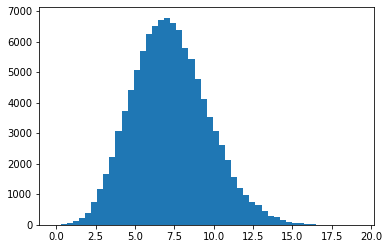

In [17]:
plt.hist(e.calc_preds(ei_train), bins=50)

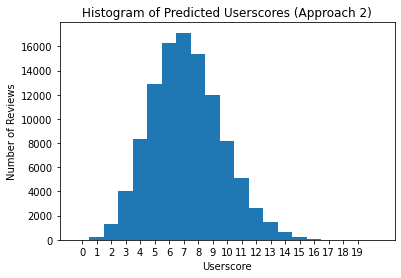

In [36]:
fig = plt.figure()
ax = plt.axes()

num_bins = 20
ax.hist(e.calc_preds(ei_train), bins=np.arange(num_bins+2)-0.5)

plt.xticks(np.arange(num_bins))

plt.title("Histogram of Predicted Userscores (Approach 2)")
plt.xlabel("Userscore")
plt.ylabel("Number of Reviews")

plt.savefig("figures/em_2_histogram.pdf")

plt.show()

In [19]:
preds_list = []
e = Embeddings(embed_dim, n_users, n_games, n_range, seed)
model = EmbeddingMatricesModel(e)

for _ in range(8):
    model.train(ei_train, alpha=0.1, n_range=n_range, cycles=1, constraint=True)
    preds_list.append(e.calc_preds(ei_train))

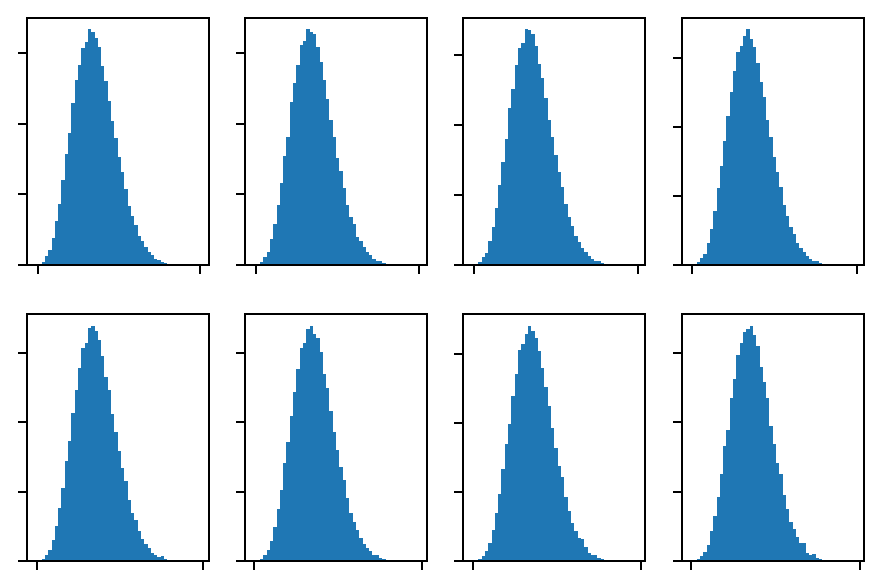

In [26]:
fig, axs = plt.subplots(2, 4, dpi=180)

for i, ax in enumerate(axs.flat):
    ax.hist(preds_list[i], bins=50)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.show()